# Optimizing Driver Allocation with Time Series Forecasting for Sweet Lift Taxi

Sweet Lift Taxi seeks to improve operational efficiency by better aligning driver availability with customer demand. To support this goal, this project will develop a time series forecasting model to predict the number of taxi orders expected in the next hour. Accurate short-term forecasts will enable the company to proactively deploy drivers during periods of high demand, enhancing customer service and reducing wait times.

The data contains historical records of taxi orders. The key variable of interest reflects the number of ride requests at specific time intervals. As a first step, the data will be loaded and resampled to an hourly frequency, preparing it for time series analysis. The project will then proceed with exploratory data analysis to identify trends, seasonality, and any irregularities that may influence model performance.

Several forecasting models will be trained and evaluated using different hyperparameters to determine the most accurate approach. A portion of the dataset—10% of the total observations—will be reserved as a test set to simulate performance on unseen data. Model effectiveness will be assessed using the Root Mean Squared Error (RMSE), with a target performance threshold of 48 or lower.

## Preparation

In [1]:
import pandas as pd
from pandas import to_datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

import lightgbm as lgb
from lightgbm.callback import early_stopping
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [2]:
taxis = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxis.sort_index(inplace=True)
taxis

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
taxis['num_orders'].sum()

372811

The taxis dataset includes data for 372,811 rides over a 6-month period in 2018.  Rides are grouped by 10-minute periods.  To enable analysis in 1-hour segments, I will resample the data so that total rides are grouped by hour.

In [5]:
taxis = taxis.resample('1H').sum()
taxis

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
taxis.isna().sum()

num_orders    0
dtype: int64

## Analysis
With the data now grouped by hour, we can begin to analyze trends.

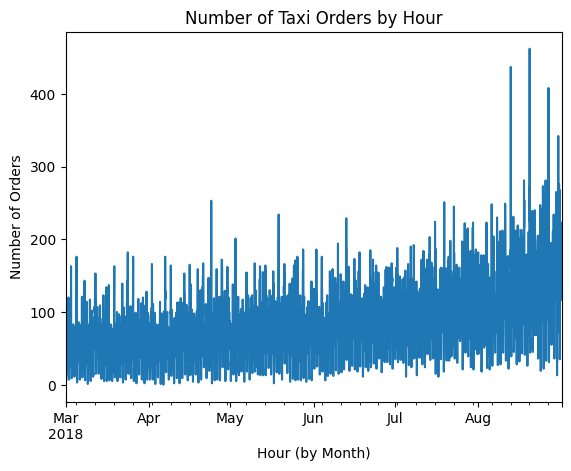

In [7]:
taxis.plot()
plt.title('Number of Taxi Orders by Hour')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.legend().remove()
plt.show()

An initial glimpse at the data shows a slight upward trend with rides peaking in the 400s in August.  However, this plot crowds a lot of data into limited space, so it does not tell much.

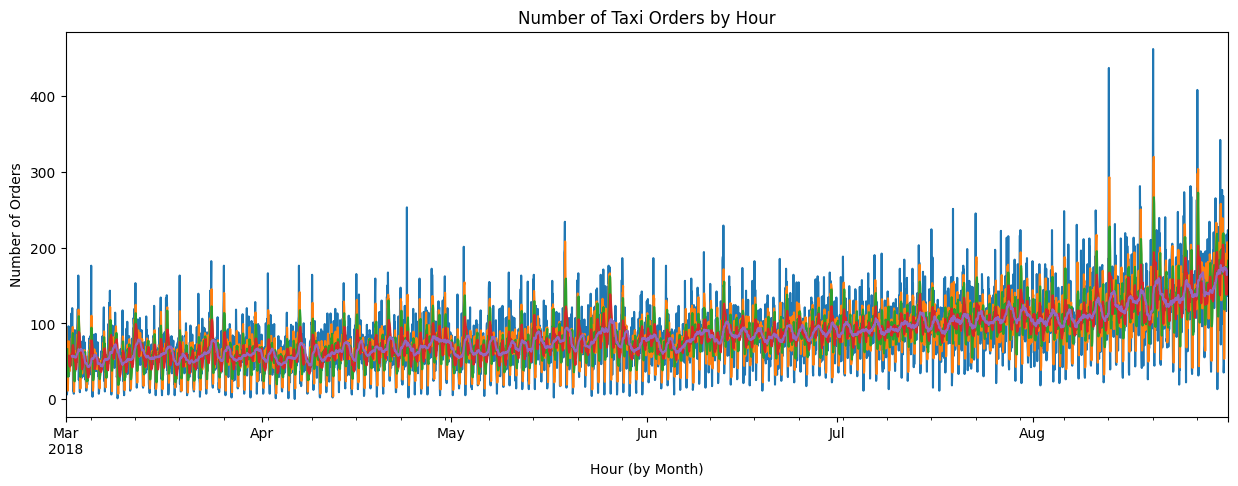

In [8]:
taxis['rolling_mean_3'] = taxis['num_orders'].rolling(3).mean().shift(1)
taxis['rolling_mean_6'] = taxis['num_orders'].rolling(6).mean().shift(1)
taxis['rolling_mean_12'] = taxis['num_orders'].rolling(12).mean().shift(1)
taxis['rolling_mean_24'] = taxis['num_orders'].rolling(24).mean().shift(1)
taxis.plot(figsize=(15, 5))
plt.title('Number of Taxi Orders by Hour')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.legend().remove()
plt.show()

By showing the rolling average by 3, 6, 12, and 24-hour period, this graph confirms the existence of a slight upward trend in the data and also reveals a small peak in rides in late May.  While there were several outlier hours in August, the rolling mean allows us to see how the average number of rides increases--but not drastically--in August.

### Making Features for Further Analysis

In [9]:
def make_features(data):
    data = data.copy()
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['week_number'] = data.index.isocalendar().week.astype(np.int32)
    data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)
    
    data['lag_1'] = data['num_orders'].shift(1)   # Previous hour
    data['lag_2'] = data['num_orders'].shift(2)   # Two hours ago
    data['lag_3'] = data['num_orders'].shift(3)   # Three hours ago
    data['lag_24'] = data['num_orders'].shift(24) # Same hour yesterday
    data['lag_48'] = data['num_orders'].shift(48) # Same hour two days ago
    data['lag_168'] = data['num_orders'].shift(168) # Same hour last week
    return data

taxis = make_features(taxis)
taxis.head()

,num_orders,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24,day,hour,dayofweek,week_number,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_48,lag_168
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,1,0,3,9,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,1,1,3,9,0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN,NaN,1,2,3,9,0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,93.333333,NaN,NaN,NaN,1,3,3,9,0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,74.000000,NaN,NaN,NaN,1,4,3,9,0,66.0,71.0,85.0,NaN,NaN,NaN


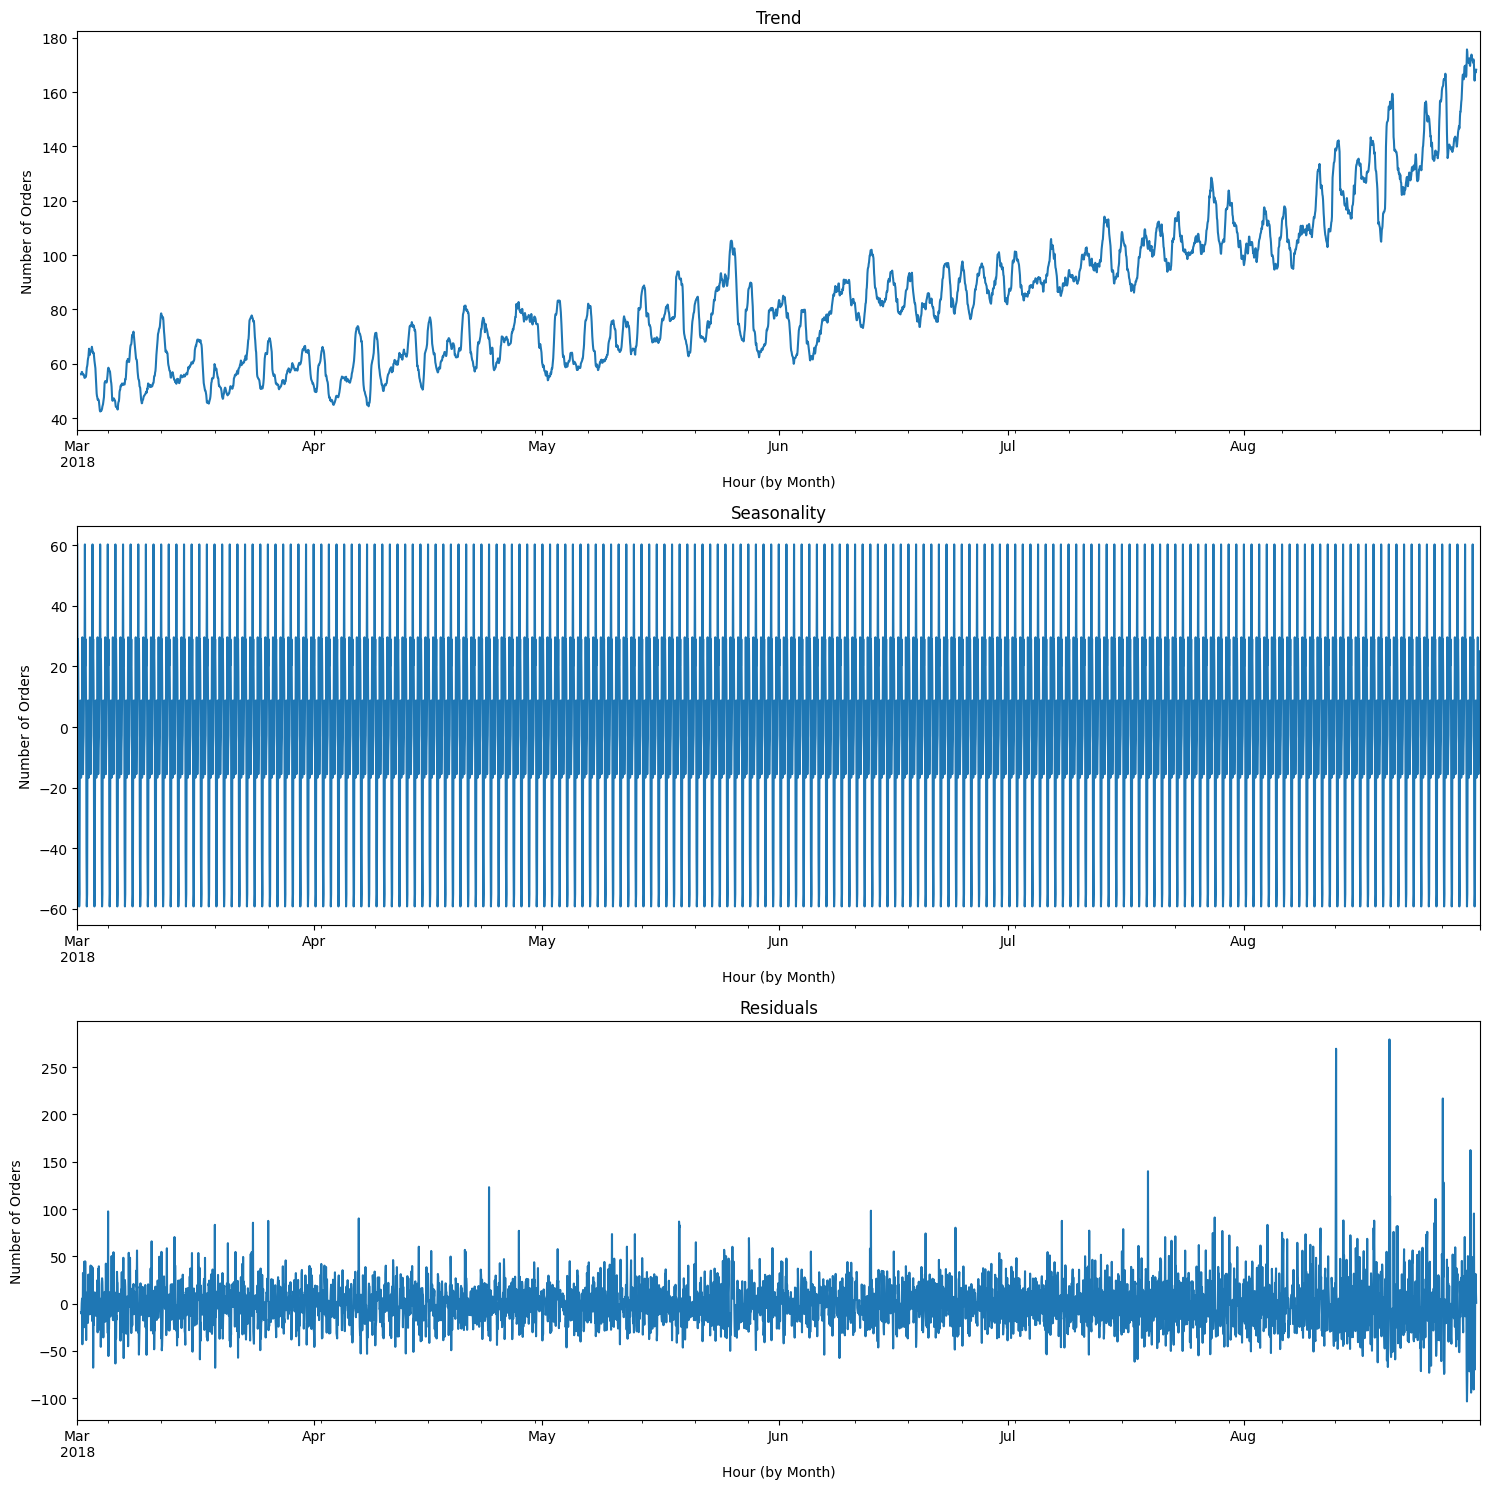

In [67]:
decomposed = seasonal_decompose(taxis['num_orders'], period=24)

plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

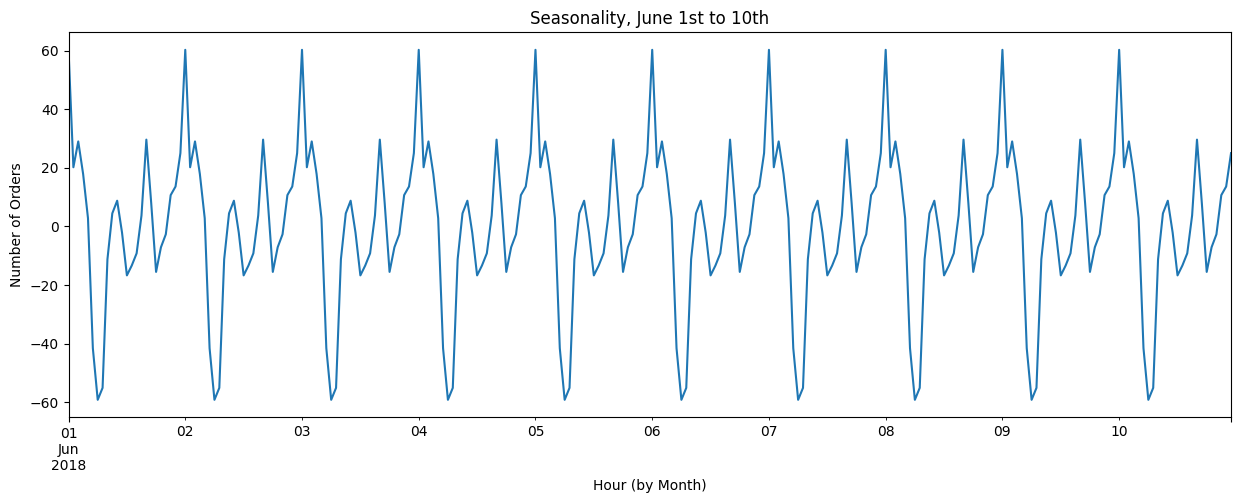

In [68]:
decomposed.seasonal['2018-06-01': '2018-06-10'].plot(figsize=(15, 5))
plt.title('Seasonality, June 1st to 10th')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.show()

The Trend graph confirms the nonstationary nature of the data and the upward trend previously identified.  The seasonality to the data is on a daily basis with an amplitude of 120.  The residuals graph shows overall consistent taxi ride demand with a mean of 0.

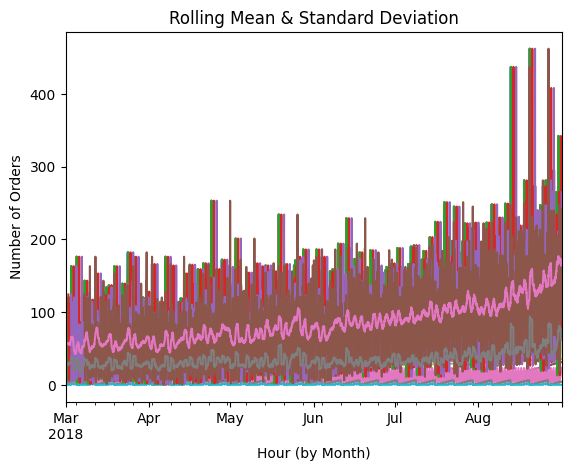

In [69]:
taxis['lag_24'] = taxis['num_orders'].shift(24)
taxis['mean'] = taxis['num_orders'].rolling(24).mean()
taxis['std'] = taxis['num_orders'].rolling(24).std()
taxis.plot()
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Hour (by Month)')
plt.ylabel('Number of Orders')
plt.legend().remove()
plt.show()

The number of orders and rolling mean are highly volatile with notable spikes in late April and August, perhaps due to tourism.  However, the mean remains stable throughout the set and the standard deviation is consistent, indicating that variability is steady throughout the period of the data.  Thus, there is only a daily seasonal trend to the data.

## Training

I'll implement a Random Forest, XGBoost, LightGBM and CatBoost model to see which performs best on an initial run.  I'll then tune hyperparameters for the most promising model.

### Defining Variables

In [70]:
taxis.dropna(inplace=True)
taxis

,num_orders,rolling_mean_3,rolling_mean_6,rolling_mean_12,rolling_mean_24,day,hour,dayofweek,week_number,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_48,lag_168,mean,std
datetime,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,109.666667,92.333333,69.250000,60.041667,8,0,3,10,0,94.0,127.0,108.0,100.0,42.0,124.0,61.833333,36.452073
2018-03-08 01:00:00,78,121.333333,99.666667,78.333333,61.833333,8,1,3,10,0,143.0,94.0,127.0,121.0,75.0,85.0,60.041667,34.417487
2018-03-08 02:00:00,65,105.000000,104.333333,80.250000,60.041667,8,2,3,10,0,78.0,143.0,94.0,24.0,36.0,71.0,61.750000,33.557543
2018-03-08 03:00:00,68,95.333333,102.500000,82.083333,61.750000,8,3,3,10,0,65.0,78.0,143.0,66.0,49.0,66.0,61.833333,33.571037
2018-03-08 04:00:00,60,70.333333,95.833333,83.500000,61.833333,8,4,3,10,0,68.0,65.0,78.0,73.0,30.0,43.0,61.291667,33.487803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,207.000000,172.666667,163.416667,164.875000,31,19,4,35,0,207.0,217.0,197.0,72.0,169.0,113.0,167.541667,63.268908
2018-08-31 20:00:00,154,186.666667,167.666667,170.916667,167.541667,31,20,4,35,0,136.0,207.0,217.0,142.0,191.0,179.0,168.041667,63.105487
2018-08-31 21:00:00,159,165.666667,171.166667,168.583333,168.041667,31,21,4,35,0,154.0,136.0,207.0,198.0,170.0,166.0,166.416667,62.801908


In [71]:
features = [col for col in taxis.columns if col != 'num_orders']
X = taxis[features]
y = taxis['num_orders']

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_mean_3   4248 non-null   float64
 1   rolling_mean_6   4248 non-null   float64
 2   rolling_mean_12  4248 non-null   float64
 3   rolling_mean_24  4248 non-null   float64
 4   day              4248 non-null   int64  
 5   hour             4248 non-null   int64  
 6   dayofweek        4248 non-null   int64  
 7   week_number      4248 non-null   int32  
 8   is_weekend       4248 non-null   int64  
 9   lag_1            4248 non-null   float64
 10  lag_2            4248 non-null   float64
 11  lag_3            4248 non-null   float64
 12  lag_24           4248 non-null   float64
 13  lag_48           4248 non-null   float64
 14  lag_168          4248 non-null   float64
 15  mean             4248 non-null   float64
 16  std             

### Splitting the Data

In [73]:
test_size = 0.1
split_idx = int(len(taxis) * (1 - test_size))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training data from: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from: {X_test.index.min()} to {X_test.index.max()}")

Training data from: 2018-03-08 00:00:00 to 2018-08-14 06:00:00
Testing data from: 2018-08-14 07:00:00 to 2018-08-31 23:00:00


### Encoding the Data

In [74]:
ohe = OneHotEncoder(dtype='int', sparse=False, handle_unknown='ignore')
ohe.fit(X_train[['day', 'hour', 'dayofweek', 'week_number']])

def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['day', 'hour', 'dayofweek', 'week_number']]), 
                           columns=ohe.get_feature_names(['day', 'hour', 'dayofweek', 'week_number']))
    df = df.drop(columns=['day', 'hour', 'dayofweek', 'week_number']).reset_index(drop=True)
    df = pd.concat([df, temp_df], axis=1)
    return df

In [75]:
X_train = get_ohe(X_train)
X_test = get_ohe(X_test)

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3823 entries, 0 to 3822
Data columns (total 99 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rolling_mean_3   3823 non-null   float64
 1   rolling_mean_6   3823 non-null   float64
 2   rolling_mean_12  3823 non-null   float64
 3   rolling_mean_24  3823 non-null   float64
 4   is_weekend       3823 non-null   int64  
 5   lag_1            3823 non-null   float64
 6   lag_2            3823 non-null   float64
 7   lag_3            3823 non-null   float64
 8   lag_24           3823 non-null   float64
 9   lag_48           3823 non-null   float64
 10  lag_168          3823 non-null   float64
 11  mean             3823 non-null   float64
 12  std              3823 non-null   float64
 13  day_1            3823 non-null   int64  
 14  day_2            3823 non-null   int64  
 15  day_3            3823 non-null   int64  
 16  day_4            3823 non-null   int64  
 17  day_5         

### Baseline Constant Model

In [79]:
y_train_mean = y_train.mean()
y_constant = np.full_like(y_train, y_train_mean)
constant_rmse = mean_squared_error(y_train, y_constant, squared=False)
constant_rmse

38.85020563182858

### Random Forest Model

In [85]:
param_grid = {
    'n_estimators': [60, 80, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=21, n_jobs=-1)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=20, cv=TimeSeriesSplit(n_splits=3), 
                                   scoring='neg_root_mean_squared_error', random_state=21, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

best_rf.fit(X_train, y_train)
train_preds = best_rf.predict(X_train)
rf_train_rmse = mean_squared_error(y_train, train_preds, squared=False)
print('RMSE for the training set:', rf_train_rmse)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=60; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=8

Best parameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
RMSE for the training set: 8.31776878990471


With hyperparameter tuning, the RandomForest model is able to achieve an RMSE of 9.318 on the training set with 60 estimators, 5 min_samples_split, 2 min_samples_leaf, using square root to determine max_features, no max_depth, and bootstrapping disabled.

### XGBoost

In [86]:
# XGBoost Regressor with simplified hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=21
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_train)
xgb_rmse = mean_squared_error(y_train, xgb_preds, squared=False)
print('RMSE for the training set:', xgb_rmse)

RMSE for the training set: 10.863789660394842


XGBoost Regressor achieved an even better RMSE on the training set with an RMSE of 10.864 on the training set.

### LightGBM

In [87]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 0.1,
    'random_state': 21,
    'verbose': -1
}

num_boost_round = 30

start_time_lgb = time.time()
lgb_model = lgb.train(params, train_data, num_boost_round = num_boost_round)
end_time_lgb = time.time()

y_pred_lgb = lgb_model.predict(X_train)

rmse_lgb = mean_squared_error(y_train, y_pred_lgb, squared=False)

print(f"LightGBM RMSE: {rmse_lgb: .3f}")
print(f"Training time: {end_time_lgb - start_time_lgb: .3f}")

LightGBM RMSE:  20.710
Training time:  0.061


LightGBM achieves an acceptable RMSE of 20.71, though it is the highest RMSE thus far.

### CatBoost

In [88]:
cat = CatBoostRegressor(loss_function="RMSE", iterations=500, random_seed=21)

cat.fit(X_train, y_train, verbose=10)

preds = cat.predict(X_train)

rmse_train = mean_squared_error(y_train, preds, squared=False)

rmse_train

Learning rate set to 0.088907
0:	learn: 36.9885971	total: 49.7ms	remaining: 24.8s
10:	learn: 25.7222230	total: 74.9ms	remaining: 3.33s
20:	learn: 22.1227824	total: 99ms	remaining: 2.26s
30:	learn: 20.8925934	total: 123ms	remaining: 1.86s
40:	learn: 20.4423117	total: 148ms	remaining: 1.65s
50:	learn: 20.0269447	total: 172ms	remaining: 1.51s
60:	learn: 19.6657614	total: 196ms	remaining: 1.41s
70:	learn: 19.3966042	total: 220ms	remaining: 1.33s
80:	learn: 19.1197086	total: 243ms	remaining: 1.26s
90:	learn: 18.8851701	total: 266ms	remaining: 1.2s
100:	learn: 18.5888630	total: 289ms	remaining: 1.14s
110:	learn: 18.3380509	total: 311ms	remaining: 1.09s
120:	learn: 18.0177150	total: 335ms	remaining: 1.05s
130:	learn: 17.7211295	total: 359ms	remaining: 1.01s
140:	learn: 17.4392630	total: 383ms	remaining: 974ms
150:	learn: 17.1854635	total: 406ms	remaining: 938ms
160:	learn: 16.9343859	total: 430ms	remaining: 905ms
170:	learn: 16.7260805	total: 454ms	remaining: 873ms
180:	learn: 16.5172335	tota

10.92243124519292

CatBoost achieves an RMSE of 10.922 on the training set, just slightly above XGBoost's RMSE.

## Testing

Given that the Random Forest model performed the best, it seems to be the ideal model for Sweet Lift.  However, I will test it alongside the second best model, XGBoost, with the test set to ensure its performance is still the best on the test data given the nonstationary nature of the data.

In [89]:
test_pred_rf = best_rf.predict(X_test)
rf_test_rmse = mean_squared_error(y_test, test_pred_rf, squared=False)
print('RMSE for the test set:', rf_test_rmse)

RMSE for the test set: 39.92973698255285


In [90]:
test_preds = xgb_model.predict(X_test)
xgb_test_rmse = mean_squared_error(y_test, test_preds, squared=False)
print('RMSE for the test set:', xgb_test_rmse)

RMSE for the test set: 39.09732935429491


Surprisingly, the XGBoost model, which performed second-best on the training set, will be the best option for Sweet Lift!  The trained model achieves an RMSE of 39.097 on the test set, well below the specified maximum of 48 and slightly better than the Random Forest model's RMSE of 39.93.

### Conclusion
This project developed a predictive model to forecast the number of taxi orders for Sweet Lift Taxi company during the next hour. The goal was to build a model that could achieve an RMSE of no more than 48 on the test set, ensuring accurate predictions to help attract more drivers during peak hours.

After resampling the data from 10-minute intervals to hourly intervals, I conducted exploratory data analysis and identified a slight upward trend over time, with daily seasonality and consistent variability. Notably, demand peaked in late April and August, likely driven by tourism.

I experimented with several machine learning models, including Random Forest, XGBoost, LightGBM, and CatBoost. Initially, Random Forest demonstrated the best performance on the training data, achieving an impressive RMSE of 8.318 on the training set. However, when evaluating the models on the test data to account for the nonstationary nature of the time series, the Random Forest model proved to be slightly less reliable than the XGBoost model, which achieved an RMSE of 39.097—well within the acceptable range.

In conclusion, the XGBoost model is the optimal choice for forecasting taxi demand at Sweet Lift. Its strong performance on the test data ensures that it generalizes well, providing accurate predictions to inform driver allocation and improve service availability during peak times.